# Ансамбли. Бустинг.

## ЗАДАНИЕ I. ДОПОЛНИТЕЛЬНОЕ

**Дано**: набор данных из системы поискового антиспама.

**Требуется**: сравнить классификаторы, основанные на алгоритмических композициях, с классическими алгоритмами классификации (SVM, логистическая регрессия) и нейросетями (двуслойный персептрон).

1. Скачать данные и запустить шаблон кода на python:
```
$ python compos.py -h
$ python compos.py -tr spam.train.txt -te spam.test.txt
```
2. Подобрать параметры трёх алгоритмических композиций (RF, Adaboost, GBM), чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон.

2*. Построить графики качества классификации в зависимости от параметров алгоритмов (XGBoost, dart, LightGBM и CatBoost)

3. Построить графики качества классификации в зависимости от числа базовых моделей.

### **1.** Пример работы шаблона кода. Качество на SVM, логистической регрессии и двуслойном перцептроне.

In [10]:
!python compos.py -h

usage: compos.py [-h] [-tr TRAIN] [-te TEST] [-t TREES] [-fp FEATURES_PERCENT]

Random Forest Tutorial

optional arguments:
  -h, --help            show this help message and exit
  -tr TRAIN, --train TRAIN
                        Train file name
  -te TEST, --test TEST
                        Test file name
  -t TREES, --trees TREES
                        Number of trees in random forest
  -fp FEATURES_PERCENT, --features_percent FEATURES_PERCENT
                        Percent of features in each tree


In [11]:
!python compos.py -tr spam.train.txt -te spam.test.txt

Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.54760   0.87998   0.67509      2033
        1.0    0.96406   0.81578   0.88374      8023

avg / total    0.87986   0.82876   0.84156     10056
final score    0.75583   0.84788   0.77942     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.42450   0.58173      2033
        1.0    0.87174   0.99115   0.92762      8023

avg / total    0.88230   0.87659   0.85769     10056
final score    0.89786   0.70782   0.75467     10056

Gradient Boosting Machine :
             precision    recall  f1-score   support

        0.0    0.67793   0.84899   0.75388      2033
        1.0    0.95912   0.89779   0.92744      8023

avg / total    0.90227   0.88793   0.89235     10056
final score    0.81852   0.87339   0.84066     10056

SVM :
             precision  

In [17]:
import numpy as np
import matplotlib.pyplot as pl

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from sklearn.metrics import f1_score
#from sklearn.utils.multiclass import unique_labels
#from sklearn.decomposition import PCA


from compos import visualize_data, classification_report


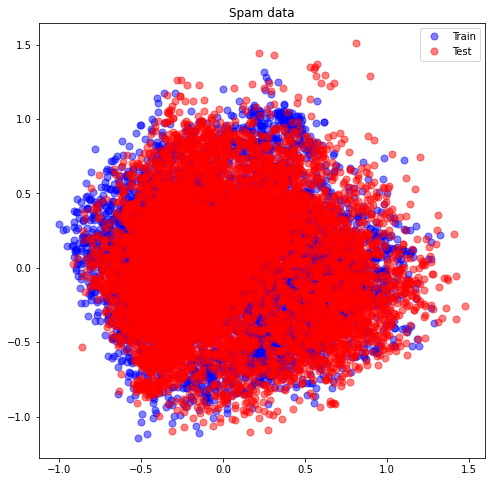

In [5]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

total_data = np.concatenate(([train_data, test_data]), axis=0)

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

#number_of_features = len(train_data[0, 1:])

In [28]:
X_train.shape, X_test.shape

((7093, 102), (10056, 102))

In [32]:
number_of_features

102

**Логистическая регрессия (параметры были подобраны в предыдущем дз)**

In [61]:
log_reg = LogisticRegression(random_state=0, C=1.0, l1_ratio=None, penalty='l1',solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Logistic regression"))

f1-score=0.9360198874787389
Logistic regression :
             precision    recall  f1-score   support

        0.0    0.68887   0.94638   0.79735      2033
        1.0    0.98499   0.89169   0.93602      8023

avg / total    0.92512   0.90274   0.90798     10056
final score    0.83693   0.91904   0.86668     10056



**SVM**

In [62]:
svm_clf = svm.SVC(kernel="rbf")
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="SVM with rbf kernel"))

f1-score=0.9585241566148487
SVM with rbf kernel :
             precision    recall  f1-score   support

        0.0    0.76980   0.97541   0.86049      2033
        1.0    0.99332   0.92609   0.95852      8023

avg / total    0.94813   0.93606   0.93870     10056
final score    0.88156   0.95075   0.90951     10056



**Двуслойный перцептрон**

In [68]:
import torch
from torch.nn import MSELoss, Linear, Sigmoid, Sequential

NN = Sequential(Linear(102, 100), Sigmoid(), Linear(100, 1))

In [69]:
def train(network, X_train, y_train, n_epoch, lrate):
    losses = []
    loss = MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=lrate)
    for _ in tqdm(range(n_epoch)):
        optimizer.zero_grad()
        out = network(X_train)
        l = loss(out, y_train)
        losses.append(l.detach().numpy())
        l.backward()
        optimizer.step()
    return losses

In [70]:
losses = train(NN, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float(), 400, 0.001)
y_pred = NN(torch.from_numpy(X_test).float())
print("f1-score={}".format(f1_score(y_test, (y_pred.detach().numpy() > 0.5).astype(int))))
print(classification_report(y_test, (y_pred.detach().numpy() > 0.5).astype(int), alg_name="Perceptron"))

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 178.17it/s]

f1-score=0.9389823900188446
Perceptron :
             precision    recall  f1-score   support

        0.0    0.70335   0.93064   0.80119      2033
        1.0    0.98086   0.90054   0.93898      8023

avg / total    0.92475   0.90662   0.91112     10056
final score    0.84210   0.91559   0.87008     10056



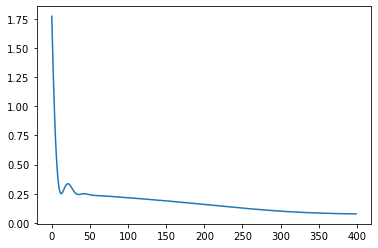

In [71]:
import matplotlib.pyplot as plt
plt.plot(losses)

### **2. и 3.** Подброр параметров для RF, Adaboost, GBM. Графики зависимости качества от числа базовых алгоритмов.

In [6]:
from sklearn.model_selection import GridSearchCV

def find_best_param(params_dict, clf, X, y):

    search = GridSearchCV(clf, param_grid=params, cv=3, n_jobs=-1)
    search.fit(X, y)
    
    return search.best_estimator_

**Random Forest**

In [47]:
params = {
        'n_estimators': range(100, 1051, 50),
        'max_features': np.linspace(0.3, 1.0, 3)
    }
RF_best = find_best_param(params, RandomForestClassifier(), X_train, y_train)

In [48]:
RF_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
y_pred = RF_best.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Random Forest"))

f1-score=0.9648922686945501
Random Forest :
             precision    recall  f1-score   support

        0.0    0.82166   0.92917   0.87211      2033
        1.0    0.98144   0.94890   0.96489      8023

avg / total    0.94913   0.94491   0.94614     10056
final score    0.90155   0.93903   0.91850     10056



In [82]:
def best_num_estim(clf, X_train, y_train, X_test, y_test, min_est, max_est, step):
    num_est = list(range(min_est, max_est, step))
    f1_scores = []
    best_score = 0
    best_n_est = 0
    best_clf = None
    for i in tqdm(range(min_est, max_est, step)):
        clf = clf.set_params(**{'n_estimators': i})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        if best_score < score:
            best_score = score
            best_n_est = i
            best_clf = clf
        f1_scores.append(score)
    plt.plot(num_est, f1_scores)
    plt.xlabel('n_estimators')
    plt.ylabel('f1-score')
    plt.title("Tuning of n_estimators parameter")
    return best_clf, f1_scores, best_n_est, best_score

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [12:59<00:00, 33.89s/it]


150

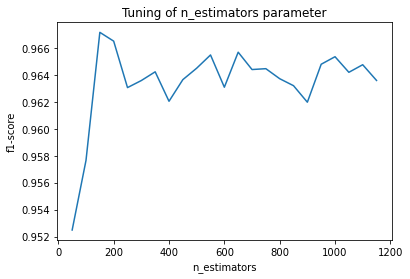

In [93]:
import matplotlib.pyplot as plt
best_RF, f1_scores, best_n_est, best_score = best_num_estim(RandomForestClassifier(max_features=0.3), X_train, y_train, X_test, y_test, 50, 1151, 50)
best_n_est

In [92]:
print("N-estimators={}".format(best_n_est))

N-estimators=250


In [91]:
y_pred = best_RF.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Random Forest"))

f1-score=0.9656698488967568
Random Forest :
             precision    recall  f1-score   support

        0.0    0.82935   0.92277   0.87357      2033
        1.0    0.97986   0.95189   0.96567      8023

avg / total    0.94943   0.94600   0.94705     10056
final score    0.90461   0.93733   0.91962     10056



**Adaboost**

In [79]:
params = {
        'n_estimators': range(50, 601, 50),
        'learning_rate': np.logspace(-2, 0, 3)
    }
ada_best = find_best_param(params, AdaBoostClassifier(), X_train, y_train)

In [80]:
ada_best

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=600, random_state=None)

In [81]:
y_pred = ada_best.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Adaboost"))

f1-score=0.9700055204563578
Adaboost :
             precision    recall  f1-score   support

        0.0    0.93468   0.81653   0.87162      2033
        1.0    0.95495   0.98554   0.97001      8023

avg / total    0.95085   0.95137   0.95012     10056
final score    0.94482   0.90103   0.92081     10056



100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [06:05<00:00, 17.41s/it]


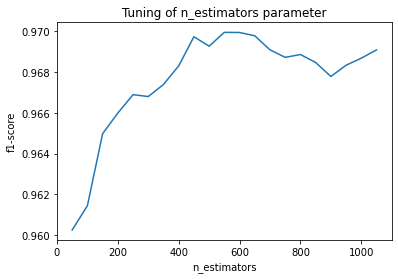

In [83]:
best_ada, f1_scores, best_n_est, best_score = best_num_estim(AdaBoostClassifier(learning_rate=0.1), X_train, y_train, X_test, y_test, 50, 1051, 50)

In [87]:
print("N-estimators={}".format(best_n_est))

N-estimators=550


In [86]:
y_pred = best_ada.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Adaboost"))

f1-score=0.9690900098911969
Adaboost :
             precision    recall  f1-score   support

        0.0    0.90279   0.84506   0.87297      2033
        1.0    0.96136   0.97694   0.96909      8023

avg / total    0.94952   0.95028   0.94966     10056
final score    0.93207   0.91100   0.92103     10056



**GBM**

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [12:26<00:00, 35.53s/it]


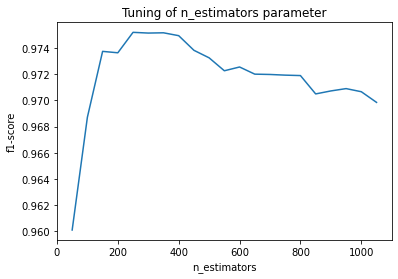

In [94]:
best_gbm, f1_scores, best_n_est, best_score = best_num_estim(GradientBoostingClassifier(), X_train, y_train, X_test, y_test, 50, 1051, 50)

In [95]:
print("N-estimators={}".format(best_n_est))

N-estimators=250


In [96]:
y_pred = best_gbm.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="GBM"))

f1-score=0.9698523892919689
GBM :
             precision    recall  f1-score   support

        0.0    0.87088   0.89572   0.88312      2033
        1.0    0.97338   0.96635   0.96985      8023

avg / total    0.95266   0.95207   0.95232     10056
final score    0.92213   0.93103   0.92649     10056



### Сравнение качества разных алгоритмов.

*total f1-score* - это f1-score, подсчитанный на всех данных.

*mean f1-score for classes* - это среднее между f1-score для классов спам и неспам.

| Algorithm | total f1-score | mean f1-score for classes |
| --- | --- | --- |
| Logistic regression | 0.9360 | 0.8666 |
| SVM | 0.9585 | 0.9095|
| Perceptron | 0.9389 | 0.8700 |
| Random forest | 0.9656 | 0.9196 |
| Adaboost | 0.9690 | 0.9210 |
| GBM | 0.9698 | 0.9264 |


### Сравнение xgboost, lightgbm и catboost

In [14]:
import xgboost as xgb
import lightgbm as lgb

## ЗАДАНИЕ II. ОСНОВНОЕ

In [6]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21
ComputeMyTaskNumber("Vakulenko_Yulia")

4

Моё задание - 4. Реализация алгоритма градиентного бустинга с логистической функцией потерь. В качестве базового алгоритма использовать алгоритм CART (задача классификации).

Логистическая функция потерь:

$$L(h) = \sum_{j=1}^{N} (-y_j \log f(x_j) - (1 - y_j)\log (1 - f(x_j)))$$

$$f(x_j) = \sigma (h(x_j)) = \frac{1}{1 + \exp^{-h(x_j)}}$$

Рассчитаем антиградиент лосс-функции. Введем обозначение $h(x_j) = h_j $.

Производная сигмоиды:
$$\sigma(h)^{'} = \sigma(h)(1 - \sigma(h))$$

Градиент:
$$\frac{\partial L(y_j, h(x_j))}{\partial h(x_j)} =  \frac{}{\partial h_j} (\sum_{k=1}^{N}(-y_k \log \sigma(h_k)  - (1 - y_k)\log (1 - \sigma(h_j)))) = \frac{}{\partial h(x_j)} (-y_j \log \sigma(h_j) - (1 - y_j)\log (1 - \sigma(h_j))) =  -y_j \frac{\sigma(h_j)(1 - \sigma(h_j))}{\sigma(h_j)} - (1 - y_j)\frac{-\sigma(h_j)(1-\sigma(h_j))}{1-\sigma(h_j)} = -y_j(1 - \sigma(h_j)) + (1 - y_j)\sigma(h_j) = \sigma(h_j) - y_j$$

Антиградиент функции потерь:
$$ -\frac{\partial L(y_j, h(x_j))}{\partial h(x_j)} = y_j - \sigma(h(x_j))$$

In [ ]:
from sklearn.base import BaseEstimator

In [ ]:
# %%pycodestyle

class MyDecisionTreeClassifier(BaseEstimator):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2,
                 max_depth=None,
                 sufficient_share=1.0,
                 criterion='gini',
                 max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    #super().get_params(self, deep=True)

    def calc_score(self, l_y, l_ny, r_y, r_ny):
        # l_y - array with y values in left subtree
        # l_ny - number of elements in left subtree
        # r_y - array with y values in right subtree
        # r_ny - number of elements in right subtree

        p_v = self.__count_prob(np.hstack((l_y, r_y)))
        p_vl =  self.__count_prob(l_y)
        p_vr = self.__count_prob(r_y)

        score = self.G_function(p_v) - self.G_function(p_vl) * l_ny/(l_ny + r_ny) -\
                                        self.G_function(p_vr) * r_ny/(l_ny + r_ny)

        return score

    def __gini(self, p):
        # p - array with proportions of different classes in a set 
        return 1 - (p*p).sum()

    def __entropy(self, p):
        # p - array with proportions of different classes in a set
        return  (p * np.log2(p)).sum()
    
    def __misclass(self, p):
        # p - array with proportions of different classes in a set
        return  1 - max(p)

    # выбор переменных для тестирования сплитов
    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(n_feature))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __count_prob(self, y):
        probs = np.count_nonzero(y == 0)
        for i in np.arange(1, self.num_class):
            probs = np.hstack(
                (probs, np.count_nonzero(
                    y == i)))
        #if y.shape[0] <= 1:
        #    print(probs)
        probs = probs / y.shape[0]
        return probs

    def __find_threshold(self, x, y):
        # фичи, которые будеи проверять на этом шаге
        features_ids = self.get_feature_ids(x.shape[1])

        # начальные условия
        min_score = -90
        best_feature = features_ids[0]
        best_threshold = x[0, best_feature]

        for feature_id in features_ids:
            #print("Checking feature {}".format(feature_id))
            # отсортированные значения фичей
            x_t, _ = self.__sort_samples(x[:,feature_id], y)
            x_t = np.unique(x_t[:-1])

            # начальные условия для цикла по фиче
            cur_best_th = x_t[0]
            cur_best_score = -90

            for val in x_t:
                x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_id, val)
                GOOD_SPLIT_SIZE = (x_l.shape[0] >= self.min_samples_split) \
                                    and (x_r.shape[0] >= self.min_samples_split)
                if GOOD_SPLIT_SIZE:
                    cur_score = self.calc_score(y_l, y_l.shape[0],\
                                               y_r,\
                                               y_r.shape[0])

                    if cur_best_score < cur_score:
                        cur_best_th = val
                        cur_best_score = cur_score


            x_l, x_r, _, _ = self.__div_samples(x, y, feature_id, cur_best_th)

            GOOD_SPLIT_SIZE = (x_l.shape[0] >= self.min_samples_split) \
                                and (x_r.shape[0] >= self.min_samples_split)
            if cur_best_score > min_score and GOOD_SPLIT_SIZE:
                best_feature = feature_id
                best_threshold = cur_best_th
                min_score = cur_best_score

        if min_score == -90:
            return (None, None, None)
        else:
            self.feature_importances_[best_feature] += min_score
            return best_feature, best_threshold, min_score

    def __fit_node(self, x, y, node_id, depth):

        p_v = self.__count_prob(y)
        if np.any(p_v >= self.sufficient_share):
            NON_LEAF_CONDITION = False
        elif self.max_depth:
            NON_LEAF_CONDITION = depth < self.max_depth \
                                    and x.shape[0] >= self.min_samples_split
        else:
            NON_LEAF_CONDITION = x.shape[0] >= self.min_samples_split

        if NON_LEAF_CONDITION:
            depth += 1
            node_feature, node_threshold, feature_score = self.__find_threshold(x, y)
            if feature_score == None:
                node_type = self.__class__.LEAF_TYPE
                c = int(np.where(p_v == p_v.max())[0][0])
                self.tree[node_id] = (node_type, c, p_v)  
            else:
                node_type = self.__class__.NON_LEAF_TYPE
                self.tree[node_id] = (node_type, node_feature, node_threshold)

                x_left, x_right, y_left, y_right = self.__div_samples(x,\
                                                                      y,\
                                                                     node_feature,\
                                                                    node_threshold)

                self.__fit_node(x_left, y_left, node_id * 2 + 1, depth)
                self.__fit_node(x_right, y_right, node_id * 2 + 2, depth)
        else:
            node_type = self.__class__.LEAF_TYPE
            c = int(np.where(p_v == p_v.max())[0][0])
            self.tree[node_id] = (node_type, c, p_v)

    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        # node = (type, feature_id, threshold)
        # feature_id - номер признака
        # threshold - порог для признака
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [ ]:
class GBM():
    def __init__(self, n_estimators, learning_rate, max_depth=3, estimator):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.base_model = base_model
        
        # coefficients for estimators
        self.b = []
        # list with estimators
        self.a = []

    # logistic fuction
    def __sigmoid(self, h):
        return 1/(1 + np.exp(-h))

    def __negative_grad(self, y, h):
        return y - self.__sigmoid(h)
    

    
    def calc_bi():
        pass
    
    def fit(self, X, y):
        # initial prediction is set to be zeros
        h_old = np.zeros(y.shape[0])
        
        for i in range(n_estimators):

            # vector with antigradients
            g_i = self.__negative_grad(y, h_i)
            # i-th estimator
            a_i = self.base_model(max_depth=self.max_depth).fit(X, g_i)
            #prediction of i-th estimator
            h_i = a_i.predict(X)
            
            
            b_i = self.calc_bi(y, h_old, h_i)
            
            self.b.append(b_i)
            self.a.append(a_i)
            
            h_i = h_old + b_i * h_i
        return h_i  
    
    def predict(self, X):
        pass
    def predict_proba(self, X):
        pass
    

In [7]:
y = np.arange(10)

In [9]:
x = np.arange(10, 20, 1)

In [13]:
h_0 = np.zeros(y.shape[0])

In [14]:
y -  1/(1 + np.exp(-h_0))

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5])